Multivariate Gaussian and Neural Networks

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../input/creditcard.csv')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

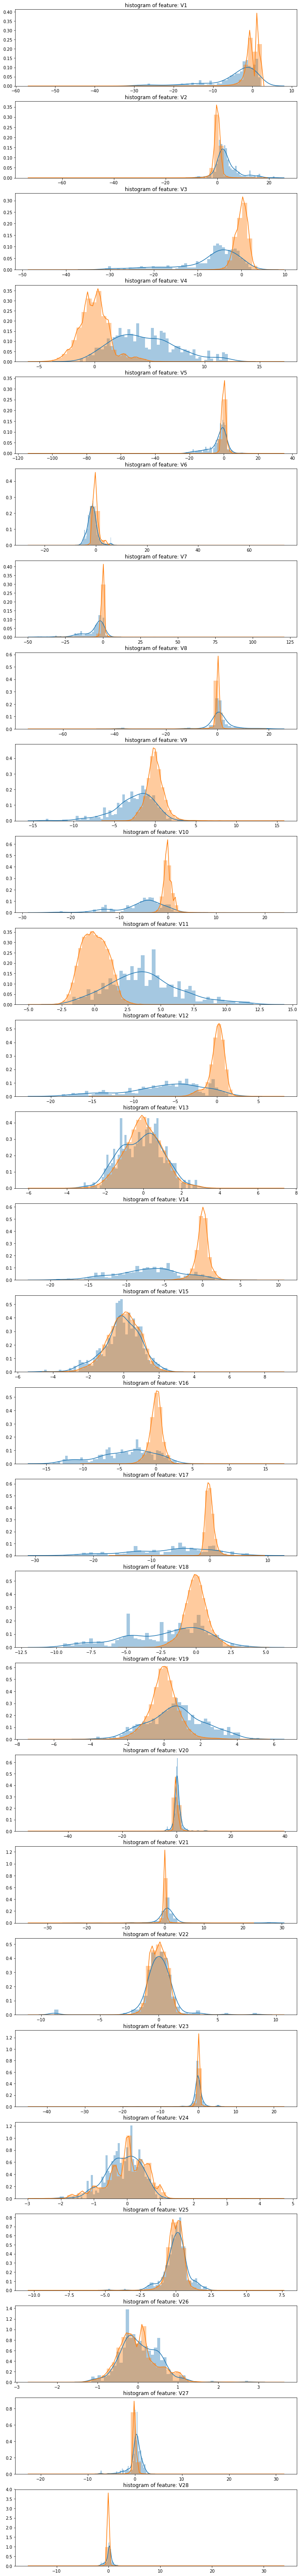

In [3]:
# Distributions for each feature
v_features = data.ix[:,1:29].columns

# Plotting features
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 1], bins=50)
    sns.distplot(data[cn][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show() 

In [4]:
# Drop out the similar features
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V5','V6','V7','V8','Time','Amount'], axis =1)

In [5]:
# Only legal transactions are used to set Mu and Sigma
normal = data[data.Class == 0]
fraud = data[data.Class == 1]

# Splits the data in training_set (60%) and test_set (40%)
X_train = normal.sample(frac = 0.6)
X_CV = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)
X_test = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)

# Drops the label
y_train, y_cv, y_test = X_train.pop('Class'), X_CV.pop('Class'), X_test.pop('Class')

m, n = X_train.shape

# Drops the label
normal_y = normal.pop('Class')
fraud_y = fraud.pop('Class')

Multivariate Gaussian
---------------------

<h2><center>$$\mu = \frac{1}{m} \sum_{i=0}^m x^i$$</center></h2>                  
<h2><center>$$\Sigma = \frac{1}{m} \sum_{i=0}^m (x^i - \mu)(x^i - \mu)^T$$</center></h2>
<h3><center>Given a new example X</center></h3>  
<h2>$$p(X) = \frac{1}{(2\pi)^\frac{n}{2}\left|\Sigma\right|^\frac{1}{2}}\exp{\left(-\frac{1}{2}(X - \mu)^T\Sigma^{-1}(X - \mu)\right)}$$</h2>


I will try to implement Multivariate Gaussian from scratch
----------------------------------------------------------



In [6]:
#Multivariable Gaussian Distribution

#Computes Mu
def mu(X):
    _mu = np.zeros((n, 1))
    for i in range(n):
        _mu[i] = (1 / m) * np.sum(X[:,i])
    return _mu

#Computes Sigma
def sigma(X):
    _sigma = np.zeros((n, 1))
    _mu = mu(X)
    for i in range(n):
        _sigma[i] = (1 / m) * np.sum(np.dot(X[:, i] - _mu, (X[:, i] - _mu).T))
    
    return _sigma
    
#Computes Expected value
def p(X, Mu, Sigma):
    k = Mu.shape[0]
    if Sigma.shape[0] == 1 or Sigma.shape[1] == 1:
        Sigma = np.diag(Sigma[:, 0])
    
    X = X - Mu.T
    r = (2 * np.pi) ** (-k / 2) * np.linalg.det(Sigma) ** (-0.5)
    e = np.exp(-0.5 * np.sum(np.dot(X , np.linalg.pinv(Sigma)) * X, 1))
    
    return r * e    

#Find the best value for epsilon
def select_threshold(predictions_CV, Y_CV):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (np.max(predictions_CV) - np.min(predictions_CV)) / 1000
    
    for epsilon in np.arange(min(predictions_CV), max(predictions_CV), stepsize):
        pred = np.array(predictions_CV < epsilon, dtype = int)
        F1 = f1_score(pred, Y_CV, average = 'macro')
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    print('Best F1: ', F1, ' | Best Epsilon: ', bestEpsilon)
    
    return bestEpsilon         

from sklearn.metrics import classification_report, average_precision_score, f1_score, recall_score, precision_score
def print_classification_report(y_test, y_predic):
    print('Classification report:')
    print(classification_report(y_test, y_predic))

    print('\nBinary F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "binary")
    Recall = recall_score(y_test, y_predic, average = "binary")
    Precision = precision_score(y_test, y_predic, average = "binary")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

    print('\nMicro F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "micro")
    Recall = recall_score(y_test, y_predic, average = "micro")
    Precision = precision_score(y_test, y_predic, average = "micro")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

In [9]:
#Fit Mu and Sigma of normal train
Mu = mu(X_train.as_matrix())
Sigma = sigma(X_train.as_matrix())
pred = p(X_CV.as_matrix(), Mu, Sigma)
epsilon = select_threshold(pred, y_cv)

Best F1:  0.00430673740368954  | Best Epsilon:  6.762579537502831e-23


In [10]:
#Predictions for the test set
final_pred = p(X_test.as_matrix(), Mu, Sigma)
final_pred = np.array(final_pred < epsilon, dtype = int)

# Print Scores for the test set
print_classification_report(y_test, final_pred)

Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56863
          1       0.52      0.58      0.55       246

avg / total       1.00      1.00      1.00     57109


Binary F1 Score, Recall and Precision:
F1 Score 0.545106
Recall Score 0.577236
Precision Score 0.516364

Micro F1 Score, Recall and Precision:
F1 Score 0.995850
Recall Score 0.995850
Precision Score 0.995850


In [11]:
#Predictions only for fraud transactions
fraud_pred = p(fraud.as_matrix(), Mu, Sigma)
fraud_pred = np.array(fraud_pred < epsilon, dtype = int)

#Print Scores for fraud transactions
print_classification_report(fraud_y, fraud_pred)

Classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.58      0.73       492

avg / total       1.00      0.58      0.73       492


Binary F1 Score, Recall and Precision:
F1 Score 0.730323
Recall Score 0.575203
Precision Score 1.000000

Micro F1 Score, Recall and Precision:
F1 Score 0.575203
Recall Score 0.575203
Precision Score 0.575203


Neural Network Approach
-----------------------



In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [13]:
data = pd.read_csv('../input/creditcard.csv')

#All the features are used for the neural network

#Normalization and features scaling
for f in data.columns.values:
    if f != 'Class':
        mean, std = data[f].mean(), data[f].std()
        data[f] = (data[f] - mean) / std

normal = data[data.Class == 0]
fraud = data[data.Class == 1]

# Split the data - 20% of normal data + 50% of fraud
X_train = pd.concat([normal.sample(frac = 0.2),fraud.sample(frac = 0.50)], axis = 0)
X_test = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)

y_train, y_test = X_train.pop('Class'), X_test.pop('Class')

# One hot encoding
y_train = LabelEncoder().fit(y_train).transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelEncoder().fit(y_test).transform(y_test)
y_test = to_categorical(y_test)

m, n = X_train.shape
normal_y = normal.pop('Class')
y_fraud = fraud.pop('Class')

In [14]:
input_size = X_train.shape[1]
output_size = 2
hidden_size = int((2 / 3) * input_size + output_size)

model = Sequential([Dense(hidden_size, activation = 'relu', input_dim = input_size),
                    Dropout(.15),
                    Dense(hidden_size, activation = 'relu'),
                    Dropout(.10),
                    Dense(hidden_size, activation = 'relu'),
                    Dropout(.5),
                    Dense(output_size, activation = 'softmax')
                    ])

In [15]:
# Training
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit(X_train.as_matrix(), y_train, batch_size = 128,  epochs = 100, verbose = 0);

In [16]:
#Predictions
pred = model.predict(X_test.as_matrix())
y_test = y_test.argmax(1)
pred = pred.argmax(1)

#Print Scores
print_classification_report(y_test, pred)

Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56863
          1       0.98      0.85      0.91       246

avg / total       1.00      1.00      1.00     57109


Binary F1 Score, Recall and Precision:
F1 Score 0.908297
Recall Score 0.845528
Precision Score 0.981132

Micro F1 Score, Recall and Precision:
F1 Score 0.999265
Recall Score 0.999265
Precision Score 0.999265


In [17]:
#Predictions only for fraud transactions
fraud_pred = model.predict(fraud.as_matrix())
fraud_pred = fraud_pred.argmax(1)

#Print Scores
print_classification_report(y_fraud, fraud_pred)

Classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.86      0.93       492

avg / total       1.00      0.86      0.93       492


Binary F1 Score, Recall and Precision:
F1 Score 0.925764
Recall Score 0.861789
Precision Score 1.000000

Micro F1 Score, Recall and Precision:
F1 Score 0.861789
Recall Score 0.861789
Precision Score 0.861789
